### TODO list 
- first implement a visualization tool for the feature representation
    - build the VGG net
    - build the NN with white noise as an input
    - perform backpropagation with the formula given in the paper
    - DO NOT implement yet the style stuff
    - see https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573

In [1]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
# upload vgg net with its weights
vgg_net1 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True);
vgg_net1.eval();

Using cache found in /home/rotakagui/.cache/torch/hub/pytorch_vision_v0.10.0
/home/rotakagui/miniconda3/envs/jupy/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rotakagui/miniconda3/envs/jupy/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
nodes_vgg_net1 = get_graph_node_names(vgg_net1)[1]
print(nodes_vgg_net1)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'features.31', 'features.32', 'features.33', 'features.34', 'features.35', 'features.36', 'features.37', 'features.38', 'features.39', 'features.40', 'features.41', 'features.42', 'features.43', 'features.44', 'features.45', 'features.46', 'features.47', 'features.48', 'features.49', 'features.50', 'features.51', 'features.52', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [5]:
vgg_net1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [18]:
model = create_feature_extractor(vgg_net1,{'features.6':'layer1','features.13':'layer2','features.26':'layer3','features.39':'layer4','features.52':'layer5'})

Images are 512 x 512 

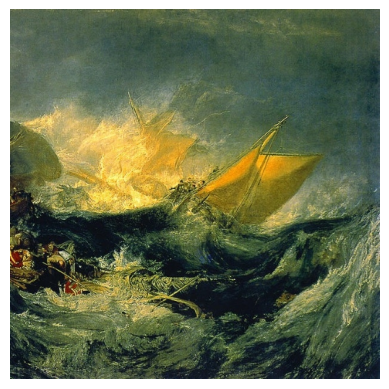

In [24]:
from PIL import Image 
import numpy as np 
import matplotlib.pyplot as plt


# load image 
image = Image.open("image.jpg")
# convert to numpy 
arr_image = np.array(image)

plt.imshow(arr_image)
plt.axis('off')
plt.show()

explore what the net produces when an image passes through different layers. we take a single filter result 

torch.Size([1, 3, 512, 512])
[('layer1', torch.Size([1, 64, 256, 256])), ('layer2', torch.Size([1, 128, 128, 128])), ('layer3', torch.Size([1, 256, 64, 64])), ('layer4', torch.Size([1, 512, 32, 32])), ('layer5', torch.Size([1, 512, 16, 16]))]


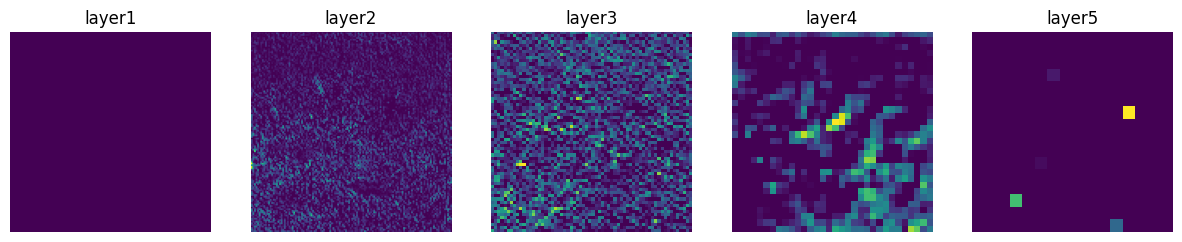

In [39]:
from torchvision import transforms

transform = transforms.ToTensor()(image)
transform = transform.unsqueeze(0)
print(transform.shape)
out = model(transform)
print([(k, v.shape) for k, v in out.items()])

# TODO: why the first layer produces an image without anything
# once we pass the three dimensions in the channel dimension, the definition of color is lost 

num_layers = len(out)  # Number of extracted layers
fig, axes = plt.subplots(1, num_layers, figsize=(15, 15))

for i, (layer_name, feature_map) in enumerate(out.items()):
    # select a single filter
    #im = v[:,0,:,:]
    im = feature_map[0, 0, :, :].detach().cpu().numpy()  # Select a single filter
    axes[i].imshow(im, cmap='viridis')
    axes[i].axis('off')
    axes[i].set_title(layer_name)
    

### Loss Content 
The idea is to have a static vgg net where we have processed the content image, so we know the result in different layers. To obtain content reconstruction we define another model in which we still use a vgg net but we attach at the begining a white noise layer that will be updated with each passing epoch, that is, we apply backpropagation to this initial layer as well.<br>
**upd:** by studying how autograd works, we understand that every tensor can be part of the DAG an so by calling `.backwards` and if certain tensor has `.required_grad=true` then it will be updated as well




In [ ]:
middle_vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True);

def my_loss(F,P):
    """
    computes the loss function for F and P tensors from layer l
    layer l is defined by user
    """
    loss = (1/2)*torch.sum((F-P)**2)
    return loss 